In [2]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import csv
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [3]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)  

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0 or row[1].find('bh') >= 0:
        label = 'Attacked'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7403:3:303:,grid_normal_2019-02-26_10:29_,147,284.144898,68940.259477,262.564772,1,70.3,1922.0,0.265,8,Normal
1,aaaa::212:7408:8:808:,grid_normal_2019-02-26_10:29_,142,449.380282,266070.776346,515.820488,2,147.0,4061.0,0.290,6,Normal
2,aaaa::212:7402:2:202:,grid_normal_2019-02-26_10:29_,138,445.862319,118132.455358,343.704023,2,128.0,2020.0,0.310,8,Normal
3,aaaa::212:740a:a:a0a:,grid_normal_2019-02-26_10:29_,147,821.863946,222070.460814,471.243526,4,347.0,3292.0,0.265,7,Normal
4,aaaa::212:7409:9:909:,grid_normal_2019-02-26_10:29_,110,758.809091,366763.770559,605.610246,3,276.0,3945.0,0.450,6,Normal


Stats for single network

In [4]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 16)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 16, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 16, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 16, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,grid_1bh-7_2019-02-19_22:13_,Attacked,0.275,0.255,0.080,0.170,0.230,0.240,0.215,0.305,0.100,0.170,0.240,0.200,0.220,0.190,9.223372e+18,9.223372e+18
1,grid_1bh-9_2019-02-20_00:30_,Attacked,0.015,0.100,0.205,0.125,0.250,0.075,0.130,0.045,0.025,0.010,0.160,0.070,0.040,0.210,9.223372e+18,9.223372e+18
2,grid_1gh30-7_2019-02-19_22:35_,Attacked,0.885,0.380,0.425,0.890,0.335,0.350,0.475,0.235,0.455,0.825,0.705,0.480,0.635,0.705,6.950000e-01,5.500000e-01
3,grid_1gh30-9_2019-02-20_00:12_,Attacked,0.220,0.790,0.155,0.155,0.320,0.105,0.070,0.180,0.125,0.760,0.115,0.220,0.060,0.120,1.800000e-01,6.500000e-02
4,grid_1gh50-7_2019-02-19_22:53_,Attacked,0.270,0.650,0.625,0.580,0.145,0.300,0.315,0.170,0.160,0.350,0.165,0.205,0.170,0.345,3.000000e-01,3.600000e-01


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

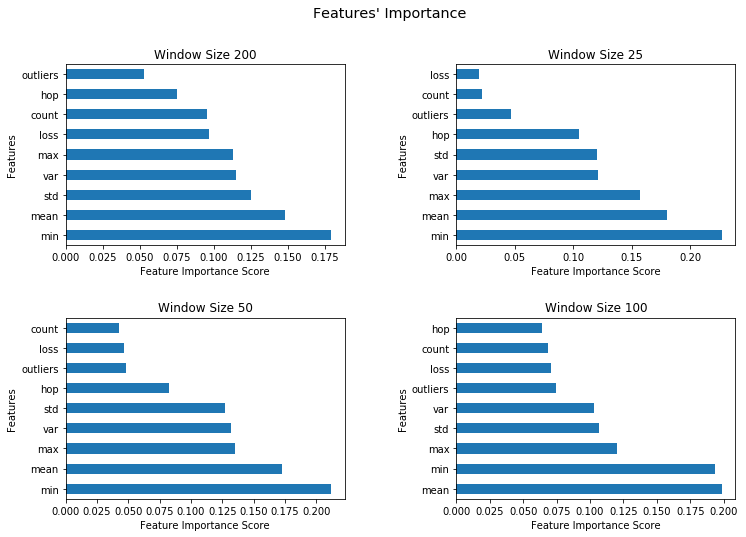

In [5]:
plots_analysis.random_forests_features_selection(trace_stats)

In [6]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [7]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [8]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [9]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [10]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

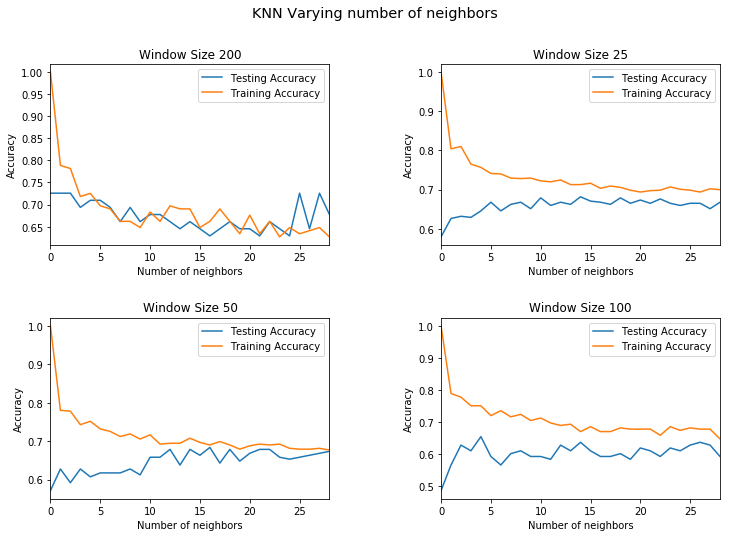

In [11]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [12]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [13]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [14]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [15]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [16]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [17]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [18]:
'''
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])
'''

"\nnet_results = pd.concat([net_results, \n                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')\n                    ])\n"

Cross validation

In [19]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [20]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [21]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [23]:
'''
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])
'''

'\nnet_results = pd.concat([net_results, \n                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)\n                    ])\n'

Cross validation

In [24]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# Per Node Results

Results from each model

In [25]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.822581,0.837589,0.770455,0.788133,0.114963,0.011089
1,Random Forest,25,0.678670,0.666377,0.632404,0.633284,0.249300,0.016341
2,Random Forest,50,0.709184,0.680070,0.676309,0.677994,0.180600,0.012656
3,Random Forest,100,0.646018,0.652083,0.626977,0.621060,0.116903,0.010834
4,KNN,200,0.677419,0.658120,0.668182,0.660088,0.019774,0.018159
5,KNN,25,0.678670,0.669218,0.628690,0.628205,0.007392,0.082552
6,KNN,50,0.658163,0.631579,0.636939,0.633338,0.004884,0.045276
7,KNN,100,0.592920,0.598792,0.564674,0.537873,0.004467,0.028487
8,SVM,200,0.661290,0.633333,0.543182,0.502864,0.008172,0.027685
9,SVM,25,0.639889,0.618067,0.580632,0.570616,0.154648,0.020306


Here we plot the average results for each model computed with cross validation

In [26]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.563293
1,Random Forest,25,0.660719
2,Random Forest,50,0.666471
3,Random Forest,100,0.593405
4,KNN,200,0.583780
5,KNN,25,0.642524
6,KNN,50,0.592719
7,KNN,100,0.556072
8,SVM,200,0.578171
9,SVM,25,0.622586


# Network Results

Here we print the results from each model on the whole network

In [27]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.5000,0.333333,0.333333,0.333333,0.134895,0.018155
1,Random Forest,25,0.5625,0.281250,0.500000,0.360000,0.144669,0.020013
2,Random Forest,50,0.5000,0.500000,0.500000,0.418182,0.118623,0.009482
3,Random Forest,100,0.5000,0.714286,0.600000,0.466667,0.135132,0.011479
4,KNN,200,0.7500,0.750000,0.833333,0.733333,0.003902,0.016561
5,KNN,25,0.5625,0.281250,0.500000,0.360000,0.004860,0.019968
6,KNN,50,0.1250,0.100000,0.125000,0.111111,0.003375,0.015273
7,KNN,100,0.3750,0.416667,0.433333,0.365079,0.003825,0.013982


Here we plot the average results for each model computed with cross validation

In [28]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.555556
1,Random Forest,25,0.577342
2,Random Forest,50,0.541667
3,Random Forest,100,0.500000
4,KNN,200,0.644444
5,KNN,25,0.567538
6,KNN,50,0.557870
7,KNN,100,0.616667
